In [1]:
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
#from helper.utils import *
from ner_crf_4 import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn_crfsuite import metrics

In [2]:
ner = NamedEntityRecognition()

In [3]:
#merged_data = read_tsv('../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../dataset/train.tsv')
val_data = read_tsv('../dataset/val.tsv')
test_data = read_tsv('../dataset/test.tsv')

In [4]:
train_data = to_token_tag_list(train_data)
val_data = to_token_tag_list(val_data)
test_data = to_token_tag_list(test_data)

In [5]:
def get_features(data):
	X = [ner.sent2features(s) for s in data]
	y = [ner.sent2tags(s) for s in data]

	return X, y

In [6]:
X_train, y_train = get_features(train_data)
X_val, y_val = get_features(val_data)
X_test, y_test = get_features(test_data)

In [7]:
print(f"Train set: {len(X_train)} sentences")
print(f"Val set: {len(X_val)} sentences")
print(f"Test set: {len(X_test)} sentences")

Train set: 4556 sentences
Val set: 1139 sentences
Test set: 2805 sentences


### CRF Training

In [8]:
model = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	max_iterations=100,
	all_possible_transitions=True,
	c1=0.1,  # Coefficient for Lasso (L1) regularization for
    c2=0.1,  # Coefficient for Ridge (L2) regularization
)

In [9]:
# train CRF
%time
model.fit(X=X_train, y=y_train, X_dev=X_val, y_dev=y_val)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [10]:
y_pred = model.predict(X_test)

In [11]:
# save model
model_name = 'crf_model_split_4.pkl'
root_path = 'model/'
joined_path = os.path.join(root_path, model_name)
pickle.dump(model, open(joined_path, 'wb'))


 Evaluation on the test data
Confusion Matrix
              precision    recall  f1-score   support

           O     0.9972    0.9984    0.9978     56762
   I-PURPOSE     0.9412    0.9820    0.9612       946
  I-HERITAGE     0.9469    0.9889    0.9674       631
   I-NATURAL     0.9511    0.9757    0.9632       658
   B-PURPOSE     0.9851    0.9060    0.9439       585
  B-HERITAGE     0.9873    0.8940    0.9383       434
   B-NATURAL     0.9801    0.8786    0.9266       618

    accuracy                         0.9949     60634
   macro avg     0.9699    0.9462    0.9569     60634
weighted avg     0.9949    0.9949    0.9948     60634



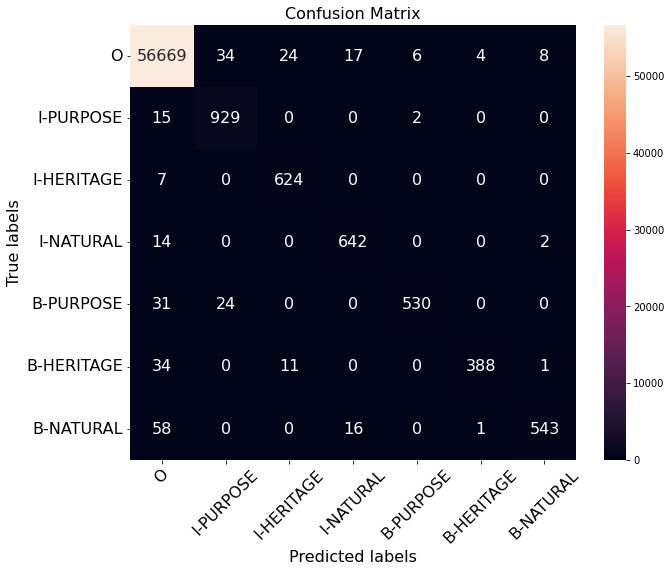

In [12]:
print('\n Evaluation on the test data')
ner.show_confusion_matrix(y_test, y_pred)

# increase font of x and y axis

In [13]:
print("\nTop likely transitions:")
ner.print_transitions(Counter(model.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
ner.print_transitions(Counter(model.transition_features_).most_common()[-20:])

# check the state features
print("\nTop positive:")
ner.print_state_features(Counter(model.state_features_).most_common(20))
print("\nTop negative:")
ner.print_state_features(Counter(model.state_features_).most_common()[-20:])


Top likely transitions:
O          -> O          2.47673
B-HERITAGE -> I-HERITAGE 1.81486
B-PURPOSE  -> I-PURPOSE  1.76551
B-NATURAL  -> I-NATURAL  1.43945
I-NATURAL  -> I-NATURAL  1.42689
I-HERITAGE -> I-HERITAGE 1.42625
I-PURPOSE  -> I-PURPOSE  1.14136
O          -> B-PURPOSE  0.87164
O          -> B-HERITAGE 0.86416
O          -> B-NATURAL  0.83678
I-HERITAGE -> O          0.05407
I-NATURAL  -> O          -0.00940
I-PURPOSE  -> O          -0.12561
B-PURPOSE  -> O          -0.22058
B-HERITAGE -> O          -0.37090
B-NATURAL  -> O          -0.56350
I-NATURAL  -> B-NATURAL  -0.81967
I-NATURAL  -> B-PURPOSE  -0.82585
O          -> I-NATURAL  -0.82642
I-HERITAGE -> B-HERITAGE -0.84999

Top unlikely transitions:
B-PURPOSE  -> B-NATURAL  -1.49621
I-HERITAGE -> B-NATURAL  -1.49828
I-PURPOSE  -> B-NATURAL  -1.52236
B-PURPOSE  -> I-HERITAGE -1.59940
B-PURPOSE  -> I-NATURAL  -1.62931
B-NATURAL  -> B-HERITAGE -1.66791
B-NATURAL  -> I-HERITAGE -1.70644
B-HERITAGE -> I-NATURAL  -1.79781
I-NATUR

In [14]:
import eli5

eli5.show_weights(model,horizontal_layout=False, show=['transition_features'])

From \ To,O,B-HERITAGE,I-HERITAGE,B-NATURAL,I-NATURAL,B-PURPOSE,I-PURPOSE
O,2.477,0.864,-3.374,0.837,-0.826,0.872,-1.172
B-HERITAGE,-0.371,-2.085,1.815,-2.176,-1.798,-2.145,-2.126
I-HERITAGE,0.054,-0.85,1.426,-1.498,-1.987,-0.962,-2.378
B-NATURAL,-0.564,-1.668,-1.706,-0.855,1.439,-2.351,-2.236
I-NATURAL,-0.009,-1.289,-1.379,-0.82,1.427,-0.826,-1.854
B-PURPOSE,-0.221,-1.427,-1.599,-1.496,-1.629,-1.453,1.766
I-PURPOSE,-0.126,-1.403,-2.137,-1.522,-2.516,-1.268,1.141


In [15]:
eli5.show_weights(model, targets=['O','B-HERITAGE','I-HERITAGE'])

In [16]:
eli5.show_weights(model, targets=['B-NATURAL','I-NATURAL','B-PURPOSE','I-PURPOSE'])